In [121]:
import pandas as pd

In [122]:
import matplotlib.pyplot as plt

In [123]:
import numpy as np
import string
import re

In [124]:
train_data = pd.read_csv("train_data.csv",names=["sentiments", "reviews"])

In [125]:
def basic_cleaning(data_frame):
    data_frame['reviews'] = data_frame.reviews.apply(lambda review: review.lower())
    data_frame['reviews'] = data_frame.reviews.apply(lambda review: review.translate(str.maketrans('', '', string.punctuation)))
    data_frame['reviews'] = data_frame.reviews.apply(lambda review: review.translate(str.maketrans('', '', string.digits)))
    data_frame['reviews'] = data_frame.reviews.apply(lambda review: re.sub("r[^a-z]",'',review))

In [126]:
basic_cleaning(train_data)

In [127]:
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize

def tokenize_data(data_frame):
    data_frame['words'] = data_frame.reviews.apply(lambda review: nltk.word_tokenize(review))

In [128]:
tokenize_data(train_data)

In [129]:
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))

def remove_stopwords(list):
    stop_words_removed = []
    for i in list:
        if i not in stopwords:
            stop_words_removed.append(i)
    return stop_words_removed



In [130]:
train_data['stop_words_cleaned'] = train_data.words.apply(lambda word_list: remove_stopwords(word_list))

In [131]:
# nltk.download('all')
def tag_pos(list_of_words):
    return nltk.pos_tag(list_of_words)

In [132]:
#extraction of lemma words after taggin with pos
from nltk.stem import WordNetLemmatizer
lemmatizer= WordNetLemmatizer()
def find_lemma_word(word):
    lemma_words=[]
    words_with_pos = tag_pos(word)
    for word in words_with_pos:
        if word[1].startswith('NN'):
            lemma_words.append(lemmatizer.lemmatize(word[0],pos='n'))
        elif word[1].startswith('VB'):
            lemma_words.append(lemmatizer.lemmatize(word[0],pos='v'))
        elif word[1].startswith('JJ'):
            lemma_words.append(lemmatizer.lemmatize(word[0],pos='a'))
        elif word[1].startswith('RB'):
            lemma_words.append(lemmatizer.lemmatize(word[0],pos='r'))
        else:
            lemma_words.append(word[0])
            
    return lemma_words

In [133]:
train_data['lemma_word'] = train_data.stop_words_cleaned.apply(lambda word_list: find_lemma_word(word_list))

In [134]:
train_data['cleaned_review'] = train_data.lemma_word.apply(lambda review_list: " ".join(review_list))

In [288]:
from sklearn.model_selection import train_test_split
train_review, test_review, train_sentiment, test_sentiment =train_test_split(train_data.cleaned_review,train_data.sentiments,shuffle=True,random_state=0,stratify=train_data.sentiments,train_size=.90)

In [338]:
from sklearn.feature_extraction.text import TfidfVectorizer
count_vectorizer = TfidfVectorizer(use_idf=False)

In [339]:
initial_features = count_vectorizer.fit_transform(train_review)

In [340]:
inital_feat_array = initial_features.toarray()

In [447]:
count_vectorizer_top_features = TfidfVectorizer(max_features=int(len(count_vectorizer.vocabulary_)*.20))

In [448]:
selected_feature_matrix = count_vectorizer_top_features.fit_transform(train_review)

In [449]:
selected_feature_array = selected_feature_matrix.toarray()
selected_test = count_vectorizer_top_features.transform(test_review)
selected_test_features = selected_test.toarray()

In [450]:
df = pd.DataFrame(selected_feature_array,columns=count_vectorizer_top_features.get_feature_names_out())

In [451]:
df['sentiments'] = np.array(train_sentiment)

In [452]:
arr = []
for i in df.columns.values:
    arr.append(i)


In [453]:
print(len(arr))
arr.remove('sentiments')
len(arr)

17170


17169

In [454]:
df_prep_chi_table = pd.DataFrame(arr, columns=['feature_variable'])
df_prep_chi_table

,feature_variable
0,aa
1,aaa
2,aabc
3,aaron
4,ab
...,...
17164,zone
17165,zoo
17166,zoolights
17167,zucchini


In [455]:
df_prep_chi_table['-1'] = df_prep_chi_table.feature_variable.apply(lambda feat: df.loc[df['sentiments']== -1, feat].sum())


In [456]:
df_prep_chi_table['+1'] = df_prep_chi_table.feature_variable.apply(lambda feat: df.loc[df['sentiments']== 1, feat].sum())



In [457]:
total_sum = df_prep_chi_table['+1'].sum()+df_prep_chi_table['-1'].sum()

In [458]:
df_prep_chi_table['sum_total'] = df_prep_chi_table['+1']+df_prep_chi_table['-1']

In [459]:
df_prep_chi_table

,feature_variable,-1,+1,sum_total
0,aa,0.246167,0.350606,0.596773
1,aaa,1.075951,1.820034,2.895985
2,aabc,0.000000,0.690025,0.690025
3,aaron,0.560970,0.791112,1.352082
4,ab,0.457404,0.262222,0.719626
...,...,...,...,...
17164,zone,1.871241,1.406961,3.278202
17165,zoo,7.991906,18.400839,26.392746
17166,zoolights,0.090298,1.026537,1.116835
17167,zucchini,3.389400,2.782847,6.172247


In [460]:
array_neg_sentiment = np.array(df_prep_chi_table['-1'])

In [461]:
array_pos_sentiment = np.array(df_prep_chi_table['+1'])

In [462]:
array_row_sum = np.array(df_prep_chi_table['sum_total'])

In [463]:
def calculate_expected_val(x ,y ,row_total, x_total, y_total, sum_total):
    exp_x=[]
    exp_y=[]
    for i in range(0,len(x)):
        exp_x.append(row_total[i]*x_total/sum_total)
        exp_y.append(row_total[i]*y_total/sum_total)
    return exp_x,exp_y

In [464]:
neg_col_sum = df_prep_chi_table['-1'].sum()
pos_col_sum = df_prep_chi_table['+1'].sum()
e_neg,e_pos = calculate_expected_val(array_neg_sentiment, array_pos_sentiment, array_row_sum,neg_col_sum ,pos_col_sum, total_sum)


In [465]:
df_exp = pd.DataFrame()

In [466]:
df_exp['+1'] = e_pos
df_exp['-1'] = e_neg
df_chi_value = pd.DataFrame()

In [467]:
df_chi_value['-1'] = ((df_prep_chi_table['-1']- df_exp['-1'])**2)/df_exp['-1']

In [468]:
df_chi_value['+1'] = ((df_prep_chi_table['+1']- df_exp['+1'])**2)/df_exp['+1']

In [469]:
df_chi_value

,-1,+1
0,0.015262,0.017127
1,0.135431,0.151978
2,0.364876,0.409455
3,0.033167,0.037220
4,0.015531,0.017429
...,...,...
17164,0.010950,0.012288
17165,2.548827,2.860236
17166,0.423777,0.475553
17167,0.004834,0.005424


In [470]:
max_chi_val = []
for row in df_chi_value.itertuples():
    max_chi_val.append(max(row[1],row[2]))

In [471]:
df_chi_value['max_chi'] = max_chi_val

In [472]:
selected_feature_array.shape

(16200, 17169)

In [473]:
ts = np.array(train_sentiment)
ts

array([ 1,  1, -1, ..., -1, -1, -1])

In [474]:
pos_weight = np.array(df_chi_value['+1'])
neg_weight = np.array(df_chi_value['-1'])
mx_weight = np.array(df_chi_value['max_chi'])

def weighted_feature(selected_feature_array, sentiment):
    weighted_feat_array = []
    ts = np.array(sentiment)
    for i in range(0, len(sentiment)):        
        if ts[i] == 1:
            weighted_feat_array.append(np.multiply(selected_feature_array[i],pos_weight))
        else:
            weighted_feat_array.append(np.multiply(selected_feature_array[i],neg_weight))
    return weighted_feat_array

In [475]:
weighted_feature_train = weighted_feature(selected_feature_array, train_sentiment)


In [476]:
weighted_feature_test = weighted_feature(selected_test_features, test_sentiment)

In [477]:
weighted_feature_train[0].shape

(17169,)

In [478]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
track_precision=[]
for i in range(3,17):
    print(i)
    classifer = KNeighborsClassifier(n_neighbors=i,n_jobs=3,weights='distance')
    classifer.fit(weighted_feature_train, train_sentiment)
    sentiments_predict = classifer.predict(weighted_feature_test)
    score = metrics.accuracy_score(test_sentiment,sentiments_predict)
    print(score)
    track_precision.append(score)

3
0.7761111111111111
4
0.7766666666666666
5
0.7877777777777778
6
0.7883333333333333
7
0.7783333333333333
8
0.7911111111111111
9
0.7877777777777778
10
0.79
11
0.7894444444444444
12
0.7955555555555556
13
0.8
14
0.8033333333333333
15
0.8022222222222222
16
0.8061111111111111


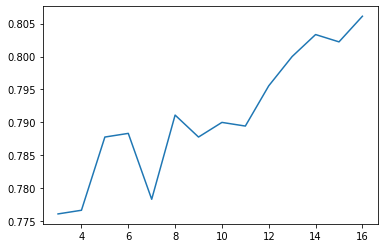

In [479]:
plt.plot(range(3,17), track_precision)